# Session 2: Binary Classification with SVM

Let's train a binary SVM classifier and evaluate its performance.

## Part 1: Linear Classifier

We will start with simple binary classification, for which we will use a toy dataset of 2d samples.

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt  
%matplotlib inline

In [2]:
from sklearn.datasets import make_blobs

feats, labels = make_blobs(n_samples = 500, n_features=2, centers=2, cluster_std=2, random_state=4242)

We can start by plotting the data in 2D:

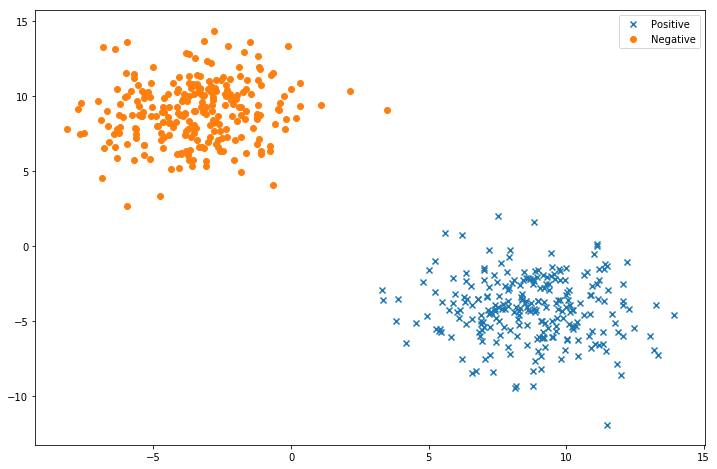

In [3]:
def plot_2d(feats,labels):
    '''
    feats: np.array of shape [n_samples,2]
    labels: np.array of shape [n_samples,]
    
    '''
    fig, ax = plt.subplots(figsize=(12,8))  
    ax.scatter(feats[labels==1][:,0],feats[labels==1][:,1], marker='x', label='Positive')  
    ax.scatter(feats[labels==0][:,0],feats[labels==0][:,1], marker='o', label='Negative')
    ax.legend()

plot_2d(feats,labels)

We can see that the dataset we generated is linearly separable. Next, we will train a classifier that will learn a boundary to separate the two data sources.

In [4]:
from sklearn import svm
svc = svm.LinearSVC(C=100,random_state=4242)
svc.fit(feats,labels)
print ("Accuracy: %f"%(svc.score(feats,labels)))

Accuracy: 1.000000


We can see that we get a perfect classification of our data. Let's now see the decision boundary plotted with our data:

In [5]:
def makemesh(X):
    
    '''
    Creates 2d point mesh to later display classifier boundary
    '''
    
    h = .02  # step size in the mesh
    
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx,yy

def plot2d_boundary(feats,labels,clf):
    
    fig, ax = plt.subplots(figsize=(12,8))  
    
    # returns 2d points representing the grid
    xx, yy = makemesh(feats)
    
    # obtain classifier values for each point in the mesh
    Z = clf.decision_function(np.c_[xx.ravel(),yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    cm = plt.cm.RdBu
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)
    
    ax.scatter(feats[labels==1][:,0],feats[labels==1][:,1], marker='x', label='Positive')  
    ax.scatter(feats[labels==0][:,0],feats[labels==0][:,1], marker='o', label='Negative')
    ax.legend() 

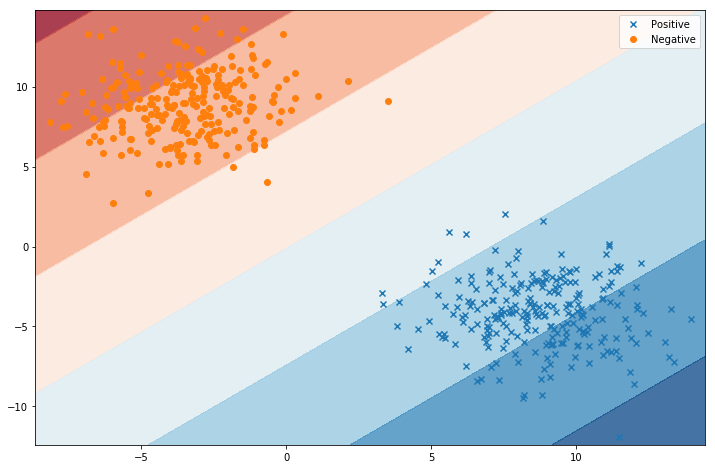

In [6]:
plot2d_boundary(feats,labels,svc)

**Exercise:** Modify values of C and check how that affects the classifier boundary.

## Part 2: Kernel trick

Now we are going to move from a linear SVM to one that is capable of non-linear classification using kernels. To illustrate its behavior we will change the dataset:

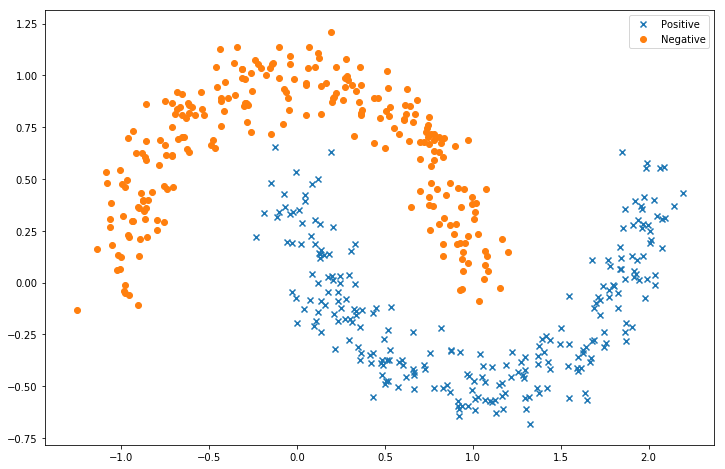

In [7]:
from sklearn.datasets import make_moons

feats, labels = make_moons(n_samples = 500, noise=0.1, random_state=4242)
plot_2d(feats,labels)

**Exercise**: Train a Linear SVM on the new data and comment on its performance on the new data.

Accuracy: 0.884000


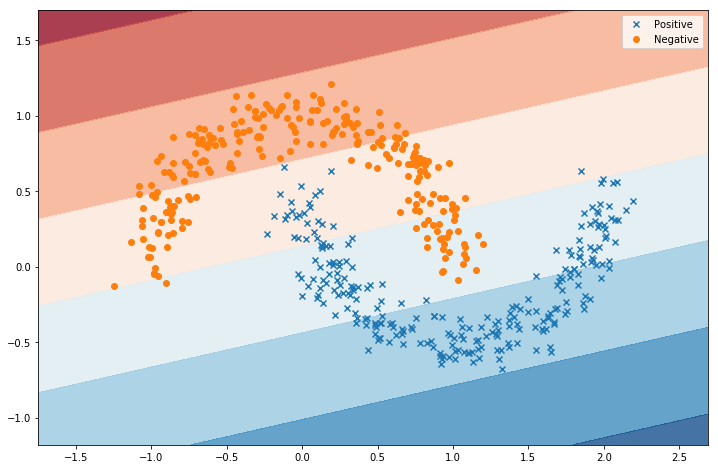

In [8]:
svc = svm.LinearSVC(C=1,random_state=4242)
svc.fit(feats,labels)
print ("Accuracy: %f"%(svc.score(feats,labels)))
plot2d_boundary(feats,labels,svc)

The linear classifier cannot perfectly separate the two data sources since they are not linearly separable.

**Exercise:** How can this be improved? Build an SVM using the built-in RBF kernel and examine its accuracy on the training data. 

Accuracy: 0.954000


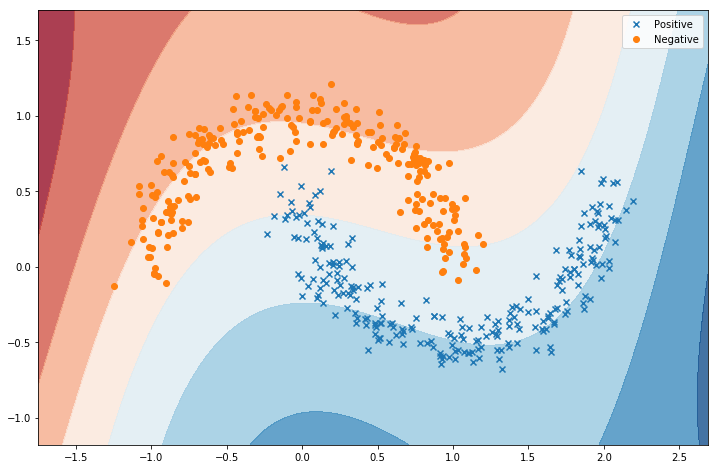

In [9]:
from sklearn.svm import SVC

svc = SVC(C=10,kernel='rbf', gamma=0.1)
svc.fit(feats,labels)
print ("Accuracy: %f"%(svc.score(feats,labels)))
plot2d_boundary(feats,labels,svc)

**Exercise:** Play with *C* and *gamma* hyperparameters and see how those affect the learned classifier boundary.

## Part 3: Evaluation metrics

### Confusion matrix

Confusion matrix, without normalization
[[238  12]
 [ 11 239]]


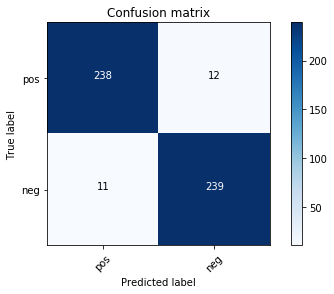

In [10]:
from sklearn.metrics import confusion_matrix
y_pred = svc.predict(feats)
cm = confusion_matrix(labels,y_pred)

from utils import *
plot_confusion_matrix(cm,classes=['pos','neg'],normalize=False,title='Confusion matrix')

### Precision & Recall Curve

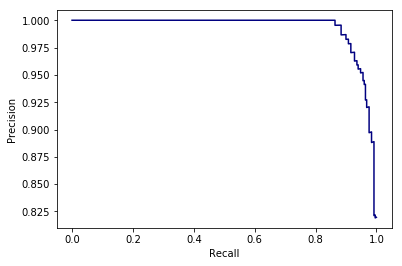

In [11]:
from sklearn.metrics import precision_recall_curve

conf = svc.decision_function(feats)
precision,recall,_ = precision_recall_curve(labels,conf)

plt.plot(recall, precision,color='navy')
plt.xlabel('Recall')
plt.ylabel('Precision')

## Part 4: Data partitions & grid-search

In this part we will train and evaluate our classifier on separate datasets. To do this, we will first need to create the partitions.

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(feats,labels,test_size=0.3, random_state= 4242)
X_train.shape,X_test.shape

((350, 2), (150, 2))

We will now train a classifier on the training set and evaluate it with the test set.

Accuracy: 0.906667


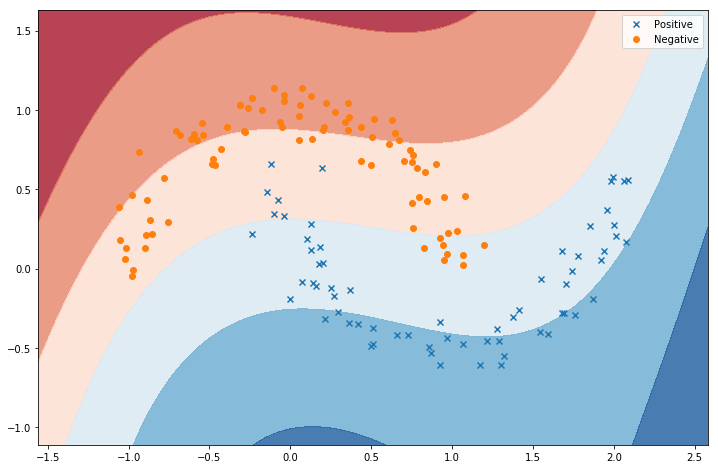

In [13]:
svc = SVC(C=10,kernel='rbf', gamma=0.1)
svc.fit(X_train,y_train)
print ("Accuracy: %f"%(svc.score(X_test,y_test)))
plot2d_boundary(X_test,y_test,svc)

Can we do better? Let's try to find the optimal *C* and *gamma* hyperparameters for the training set and see how they perform in the test set.

Accuracy: 0.986667


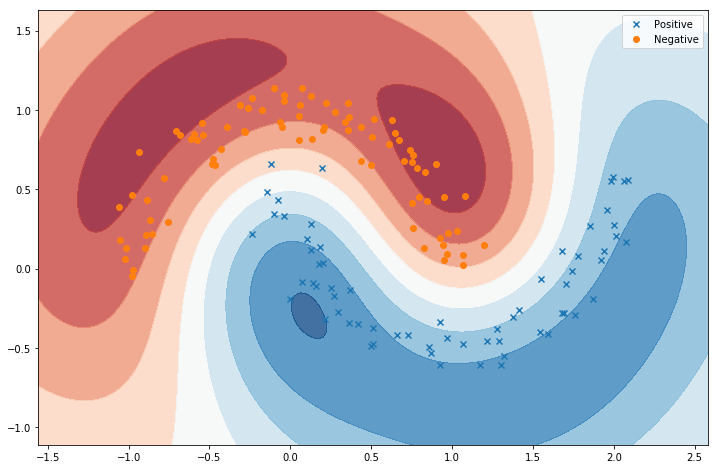

In [14]:
from sklearn.model_selection import GridSearchCV

svr = SVC()

# parameters to try
parameters = {'kernel':['rbf'], 'C':[1, 10,100],'gamma':[0.001,0.01,0.1,1.0]}

# classifier tuning with 5fold cross-validation on the training set
clf = GridSearchCV(svr,parameters,cv=5)
clf.fit(X_train,y_train)

# pick the best estimator and train it on the whole training set
svc = clf.best_estimator_
svc.fit(X_train,y_train)

# evaluation
print ("Accuracy: %f"%(svc.score(X_test,y_test)))
plot2d_boundary(X_test,y_test,svc)